In [1]:
import networkx as nx

from OperatorBenchmark import OperatorBenchmark

from typing import List, Dict

from scripts import load_profiling_data,create_profiling_data_ER,separate_keys_and_values,git_branch_commit_push,create_profiling_data_ER_HPC

from scripts_old import load_runMultipleSimpleQWAK, load_runMultipleSimpleQWAK_legacy
from datetime import datetime

import os
import re

from utils.plotTools import plot_qwak

import numpy as np
import cupy as cp
from scipy.linalg import inv, expm
import networkx as nx
import time
import cupyx.scipy.linalg as cpx_scipy
from cupyx.profiler import benchmark
from matplotlib import pyplot as plt
import os
import json
import pickle
from tqdm import tqdm
import subprocess
import random
from qwak_cupy.qwak import QWAK as CQWAK
from qwak.qwak import QWAK as QWAK
from datetime import datetime
%matplotlib inline

def process_profiling_data(path, method_name, nrange, sample_range, seed=None):
    for n in tqdm(nrange, desc="Processing n-values"):
        cumtimes = []
        for sample in sample_range:
            filename = f"{method_name}-n_{n}_sample_{sample}_pVal_0_8000_seed_{seed}.prof"
            filepath = os.path.join(path, f"n_{n}", filename)
            with open(filepath, 'r') as f:
                next(f)  # Skip the header line
                for line in f:
                    line = line.strip()
                    if not line:
                        continue
                    parts = line.split()
                    if len(parts) < 6:
                        continue
                    try:
                        cumtime = float(parts[3])
                    except (IndexError, ValueError):
                        continue
                    func_part = ' '.join(parts[5:])
                    if '(' in func_part and ')' in func_part:
                        func_name = func_part.split('(')[-1].split(')')[0]
                        if func_name == method_name:
                            cumtimes.append(cumtime)
                            break
        
        if cumtimes:
            average_cumtime = sum(cumtimes) / len(cumtimes)
            avg_folder = os.path.join(path, f"n_{n}_avg")
            os.makedirs(avg_folder, exist_ok=True)
            avg_filename = f"AVG-{method_name}-n_{n}_seed_{seed}.prof"
            avg_filepath = os.path.join(avg_folder, avg_filename)
            with open(avg_filepath, 'w') as avg_file:
                avg_file.write(f"{average_cumtime}\n")

def load_profiling_averages(path, method_name, nrange, seed=None):
    results = {}
    for n in tqdm(nrange, desc="Loading average times"):
        avg_folder = os.path.join(path, f"n_{n}_avg")
        avg_filename = f"AVG-{method_name}-n_{n}_seed_{seed}.prof"
        avg_filepath = os.path.join(avg_folder, avg_filename)
        try:
            with open(avg_filepath, 'r') as avg_file:
                results[n] = float(avg_file.readline().strip())
        except (FileNotFoundError, ValueError):
            raise ValueError(f"Average file not found or invalid format: {avg_filepath}")
    return results

def merge_by_sum(dict_a, dict_b):
    """
    Merge two dictionaries by summing the values of matching keys.
    Assumes both dictionaries have the same keys.
    """
    merged = {}
    for key in dict_a:
        merged[key] = dict_a[key] + dict_b[key]
    return merged

Profiling applied to init_operator, config: {'output_path': 'operator_results', 'output_file': None, 'tracked_attributes': ['n', 'sample', 'pVal', 'seed']}
Profiling applied to build_operator, config: {'output_path': 'operator_results', 'output_file': None, 'tracked_attributes': ['n', 'sample', 'pVal', 'seed']}
Profiling applied to build_expm_operator, config: {'output_path': 'operator_results', 'output_file': None, 'tracked_attributes': ['n', 'sample', 'pVal', 'seed']}
Profiling applied to build_multiple_operators, config: {'output_path': 'operator_anim_results', 'output_file': None, 'tracked_attributes': ['time_range', 'sample', 'pVal', 'seed']}
Profiling applied to build_multiple_expm_operator, config: {'output_path': 'operator_anim_results', 'output_file': None, 'tracked_attributes': ['time_range', 'sample', 'pVal', 'seed']}
Profiling applied to init_operator, config: {'output_path': 'operator_results_hpc', 'output_file': None, 'tracked_attributes': ['n', 'sample', 'pVal', 'seed']}

In [2]:
nMin = 3
nMax = 1000 
n_values = list(range(nMin, nMax, 1))
pVal = 0.8
sample_range = range(0, 100, 1)
seed = 10


SCRIPT_DIR = os.getcwd()
path = os.path.normpath(os.path.join(
    SCRIPT_DIR,
    "Profiling/operator_results"
))


results_init_avg = load_profiling_averages(
    path=path,
    method_name="init_operator",
    nrange=n_values,
    seed=seed
)

results_build_avg = load_profiling_averages(
    path=path,
    method_name="build_operator",
    nrange=n_values,
    seed=seed
)

results_expm_avg = load_profiling_averages(
    path=path,
    method_name="build_expm_operator",
    nrange=n_values,
    seed=seed
)

Loading average times: 100%|██████████| 997/997 [00:00<00:00, 6455.31it/s]


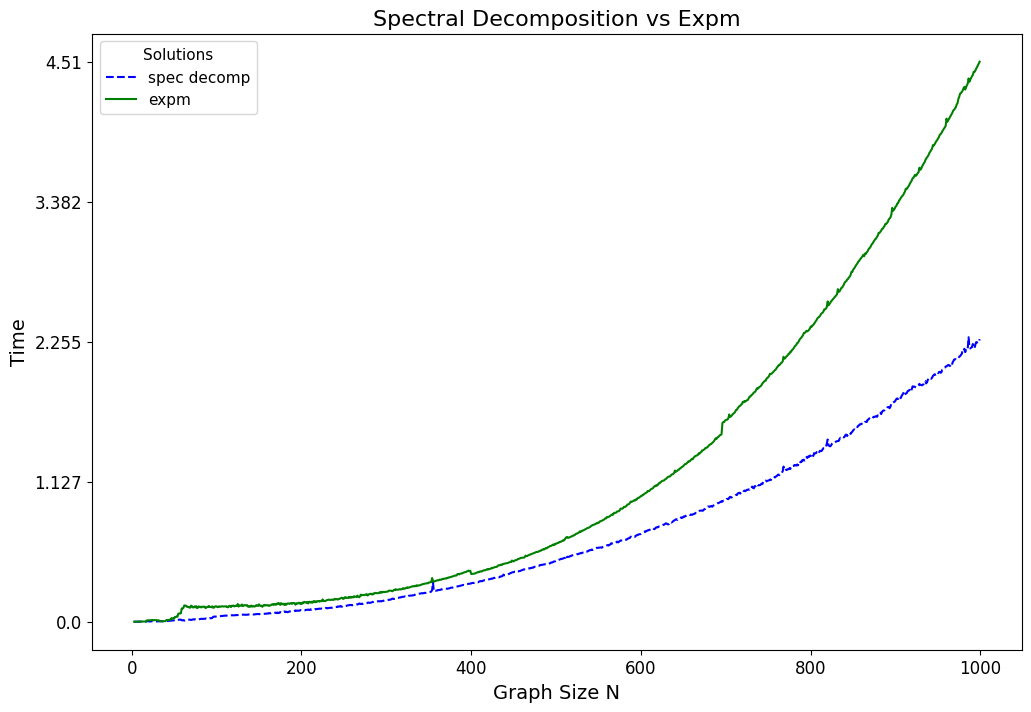

In [3]:

params = {
    'figsize': (12, 8),
    'plot_title' : f'Spectral Decomposition vs Expm',
    'x_label' : 'Graph Size N',
    'y_label' : "Time",
    'legend_labels' : ['spec decomp','expm'],
    'legend_loc': "best",
    'legend_title' : 'Solutions',
    'legend_ncol' : 1,
    # 'color_list' : ['#0000FF', '#008000', '#525252'],
    'color_list' : ['b','g','r'],
    'line_style_list' : ['--', '-','-.' ],
    'save_path' : f'ImgOutput/benchmark-OPERATOR.png',
    'use_loglog': False,
    'use_cbar' : False,
    'cbar_label' : None, 
    'cbar_ticks' : None,
    'cbar_tick_labels' : None,
    'x_lim' : None,
    # 'x_num_ticks' : 10,
    'y_num_ticks' : 5,
    'x_round_val' : 2,
    'y_round_val' : 3,
    # 'v_line_values' : v_line_values,
    # # 'v_line_style': '--',
    'title_font_size': 20,
    'xlabel_font_size': 22,
    'ylabel_font_size': 22,
    'legend_font_size': 14,
    'legend_title_font_size': 14,
    'tick_font_size': 18,}

init_build_merged_result = merge_by_sum(results_init_avg, results_build_avg)


x_value_matrix = [list(init_build_merged_result.keys()),list(results_expm_avg.keys())]
y_value_matrix = [list(init_build_merged_result.values()),list(results_expm_avg.values())]

plot_qwak(x_value_matrix = x_value_matrix, y_value_matrix = y_value_matrix,**params)

In [4]:
nMin = 3
nMax = 1000 
n_values = list(range(nMin, nMax, 1))
pVal = 0.8
sample_range = range(0, 100, 1)
seed = 10


SCRIPT_DIR = os.getcwd()
path = os.path.normpath(os.path.join(
    SCRIPT_DIR,
    "Profiling/hiperwalk_results"
))


results_init_hiperwalk_avg = load_profiling_averages(
    path=path,
    method_name="init_hiperwalk",
    nrange=n_values,
    seed=seed
)

results_build_hiperwalk_avg = load_profiling_averages(
    path=path,
    method_name="simulate",
    nrange=n_values,
    seed=seed
)

results_hiperwalk = merge_by_sum(results_init_hiperwalk_avg, results_build_hiperwalk_avg)


Loading average times: 100%|██████████| 997/997 [00:00<00:00, 6456.65it/s]


# QWAK Results - Old Method

In [10]:


# Parameters
nMin = 3
nMax = 1000
nList = list(range(nMin, nMax, 1))
pVal = 0.8
samples = 100
t = 100

# base_dir = 'Datasets/Benchmark-SimpleQWAK-Test_ER2'
# base_dir = 'Datasets/Benchmark-SimpleQWAK-Test_ER2'
# base_dir_cupy = 'Datasets/Benchmark-SimpleQWAK_ER3_CuPy'

base_dir_cupy_970 = 'Profiling\Old\Benchmark-SimpleQWAK_ER-CuPy_970'
base_dir_cupy_3070 = 'Profiling\Old\Benchmark-SimpleQWAK_ER2_CuPy_3070'
base_dir_cupy_3070_2 = 'Profiling\Old\Benchmark-SimpleQWAK_ER2_CuPy_3070_2'
base_dir = 'Profiling\Old\Benchmark-SimpleQWAK_ER-NumPy'

# runMultipleSimpleQWAK(nList, pVal, t, samples, base_dir, hpc = False)
avg_list = load_runMultipleSimpleQWAK_legacy(nList, pVal,samples, t, base_dir)

avg_list_cupy_970 = load_runMultipleSimpleQWAK_legacy(nList, pVal,samples, t, base_dir_cupy_970)

avg_list_cupy_3070_2 = load_runMultipleSimpleQWAK_legacy(nList, pVal,samples, t, base_dir_cupy_3070_2)
    
# runMultipleSimpleQWAK(nList, pVal, t, samples, base_dir_cupy_3070, hpc = True)
tList_cupy_3070, qwList_cupy_3070,avg_list_cupy_3070 = load_runMultipleSimpleQWAK(nList, pVal,samples, t, base_dir_cupy_3070)

print('CuPy QWAK results computed and saved.')

Loading NPQWAK data: 100%|██████████| 997/997 [00:00<00:00, 3568.17it/s]

CuPy QWAK results computed and saved.


# Hiperwalk

In [ ]:
nMin = 3
nMax = 1000
n_values = list(range(nMin, nMax, 1))
pVal = 0.8
sample_range = range(0, 35, 1)
seed = 10


SCRIPT_DIR = os.getcwd()
path = os.path.normpath(os.path.join(
    SCRIPT_DIR,
    "Profiling/hiperwalk_results_hpc"
))


results_init_hiperwalk_hpc_avg = load_profiling_averages(
    path=path,
    method_name="init_hiperwalk",
    nrange=n_values,
    seed=seed
)

results_build_hiperwalk_hpc_avg = load_profiling_averages(
    path=path,
    method_name="simulate",
    nrange=n_values,
    seed=seed
)

results_hiperwalk_hpc = merge_by_sum(results_init_hiperwalk_hpc_avg, results_build_hiperwalk_hpc_avg)

Loading average times: 100%|██████████| 997/997 [00:00<00:00, 6574.81it/s]


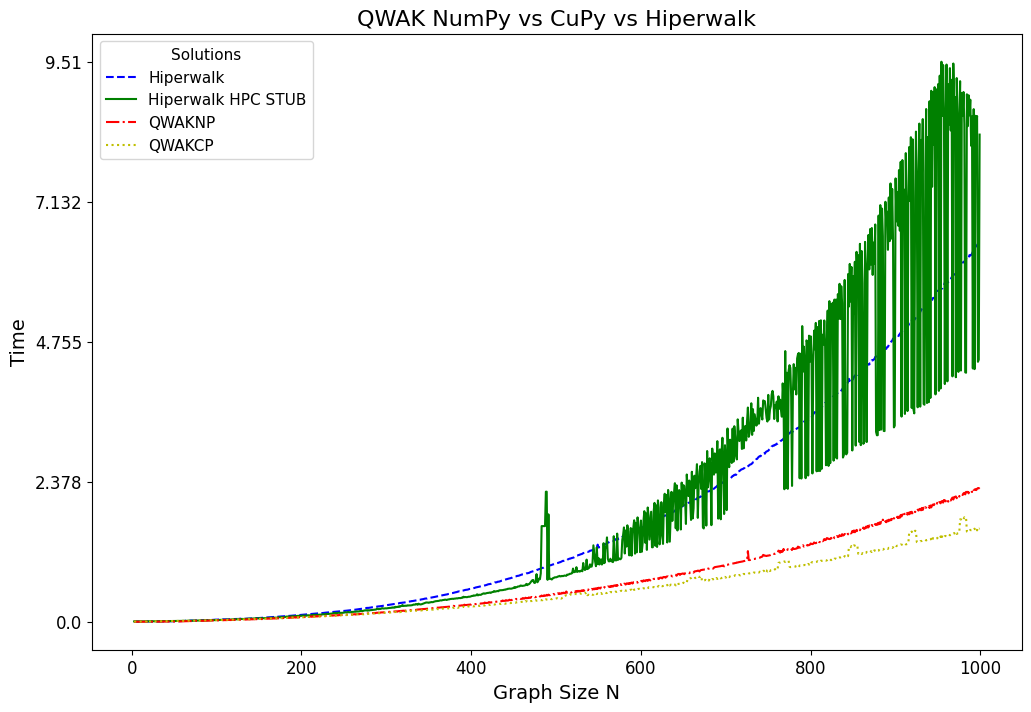

In [19]:

params = {
    'figsize': (12, 8),
    'plot_title' : f'QWAK NumPy vs CuPy vs Hiperwalk',
    'x_label' : 'Graph Size N',
    'y_label' : "Time",
    'legend_labels' : ['Hiperwalk','Hiperwalk HPC STUB', 'QWAKNP','QWAKCP'],
    'legend_loc': "best",
    'legend_title' : 'Solutions',
    'legend_ncol' : 1,
    # 'color_list' : ['#0000FF', '#008000', '#525252'],
    'color_list' : ['b','g','r','y'],
    'line_style_list' : ['--', '-','-.',':'],
    'save_path' : f'ImgOutput/benchmark-hiperwalk_hpwhpcStub_numpy_cupy_.png',
    'use_loglog': False,
    'use_cbar' : False,
    'cbar_label' : None, 
    'cbar_ticks' : None,
    'cbar_tick_labels' : None,
    'x_lim' : None,
    # 'x_num_ticks' : 10,
    'y_num_ticks' : 5,
    'x_round_val' : 2,
    'y_round_val' : 3,
    # 'v_line_values' : v_line_values,
    # # 'v_line_style': '--',
    'title_font_size': 20,
    'xlabel_font_size': 22,
    'ylabel_font_size': 22,
    'legend_font_size': 14,
    'legend_title_font_size': 14,
    'tick_font_size': 18,
    'use_grid':True,
    'marker_list': ['x', 'o']}
# # Record start datetime

# print(result_hiperwalk.keys())
x_value_matrix = [list(results_hiperwalk.keys()),list(results_hiperwalk_hpc.keys()),nList,nList]
y_value_matrix = [list(results_hiperwalk.values()),list(results_hiperwalk_hpc.values()),avg_list,avg_list_cupy_970]

plot_qwak(x_value_matrix = x_value_matrix, y_value_matrix = y_value_matrix,**params)